<a href="https://colab.research.google.com/github/Chaitanyareddynv/Cnarredd_64061/blob/main/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading the data**



In [17]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  49.4M      0  0:00:01  0:00:01 --:--:-- 49.4M


Preparing the data

In [18]:
import os, pathlib, shutil, random
from tensorflow import keras
b_size = 32
b_dir7= pathlib.Path("/content/aclImdb")
v_dir7 = b_dir7/ "val"
tr_dir7 = b_dir7 / "train"
for category in ("neg", "pos"):
    os.makedirs(v_dir7 / category, exist_ok=True )

    files = os.listdir(tr_dir7 / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    v_files = files[-num_val_samples:]
    for fname in v_files:
        shutil.move(tr_dir7 / category / fname,
                    v_dir7 / category / fname)

tr_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=b_size
).take(100)  # Restrict training samples to 100

v_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=b_size
)
te_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=b_size
)
te_only_tr_ds = tr_ds.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences

**A sequence model built on one-hot encoded vector sequences**

In [22]:
from tensorflow.keras import layers

max_l = 150   # Cutoff reviews after 150 words
max_t = 10000 # Consider only the top 10,000 word
t_vectorization = layers.TextVectorization(
    max_tokens=max_t,
    output_mode="int",
    output_sequence_length=max_l,
)
t_vectorization.adapt(te_only_tr_ds)

int_tr_ds = tr_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)
int_v_ds = v_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)
int_te_ds = te_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)

In [25]:
import tensorflow as tf  # Model with embedding layer
input = keras.Input(shape=(None,), dtype="int64")
em = layers.Embedding(input_dim=max_t, output_dim=256, mask_zero=True)(input)
x = layers.Bidirectional(layers.LSTM(32))(em)
x = layers.Dropout(0.5)(x)
ou = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input, ou)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

Developing a fundamental sequencing concept initially

In [28]:
cb = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.x",
                                    save_best_only=True)
]
hist= model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb)
model = keras.models.load_model("one_hot_bidir_lstm.x")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 [==============================] - 47s 391ms/step - loss: 0.1673 - accuracy: 0.9419 - val_loss: 0.4143 - val_accuracy: 0.8214
Epoch 2/15
100/100 [==============================] - 13s 126ms/step - loss: 0.1014 - accuracy: 0.9650 - val_loss: 0.4683 - val_accuracy: 0.8214
Epoch 3/15
100/100 [==============================] - 15s 149ms/step - loss: 0.0711 - accuracy: 0.9784 - val_loss: 0.6368 - val_accuracy: 0.7947
Epoch 4/15
100/100 [==============================] - 11s 107ms/step - loss: 0.0417 - accuracy: 0.9887 - val_loss: 0.5103 - val_accuracy: 0.8251
Epoch 5/15
100/100 [==============================] - 14s 137ms/step - loss: 0.0454 - accuracy: 0.9872 - val_loss: 0.5743 - val_accuracy: 0.8178
Epoch 6/15
100/100 [==============================] - 13s 131ms/step - loss: 0.0265 - accuracy: 0.9931 - val_loss: 0.8074 - val_accuracy: 0.7943
Epoch 7/15
100/100 [==============================] - 13s 130ms/step - loss: 0.0246 - accuracy: 0.9912 - val_loss: 0.6494 - val_ac

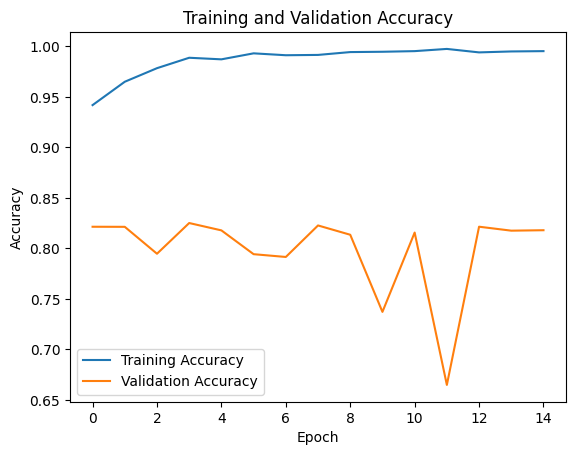

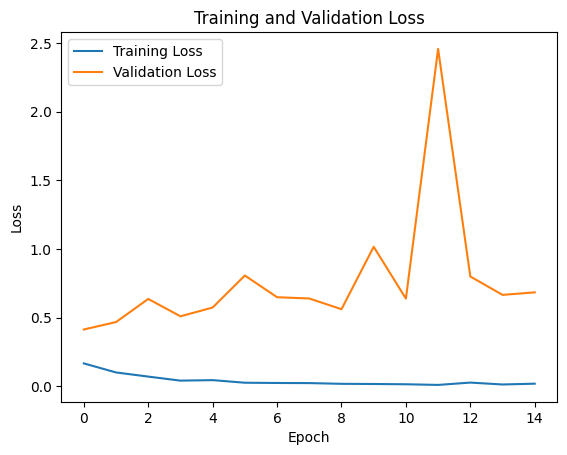

In [29]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Using the Embedded level to acquire embedded words

Putting an Anchoring level into Action


In [30]:
em_layer = layers.Embedding(input_dim=max_t, output_dim=256)

Anchor layer system which was developed form start

In [31]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=max_t, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
ou1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, ou1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [32]:
cb1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.x",
                                    save_best_only=True)
]
hist1= model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb1)
model = keras.models.load_model("embeddings_bidir_gru.x")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 [==============================] - 29s 255ms/step - loss: 0.6884 - accuracy: 0.5434 - val_loss: 0.7174 - val_accuracy: 0.5060
Epoch 2/15
100/100 [==============================] - 25s 255ms/step - loss: 0.5798 - accuracy: 0.7181 - val_loss: 0.5002 - val_accuracy: 0.7740
Epoch 3/15
100/100 [==============================] - 24s 246ms/step - loss: 0.4167 - accuracy: 0.8244 - val_loss: 0.4285 - val_accuracy: 0.8104
Epoch 4/15
100/100 [==============================] - 8s 85ms/step - loss: 0.2914 - accuracy: 0.8863 - val_loss: 0.4436 - val_accuracy: 0.8100
Epoch 5/15
100/100 [==============================] - 13s 131ms/step - loss: 0.2070 - accuracy: 0.9266 - val_loss: 0.5132 - val_accuracy: 0.7955
Epoch 6/15
100/100 [==============================] - 9s 90ms/step - loss: 0.1398 - accuracy: 0.9541 - val_loss: 0.6179 - val_accuracy: 0.7543
Epoch 7/15
100/100 [==============================] - 13s 127ms/step - loss: 0.1171 - accuracy: 0.9628 - val_loss: 0.6103 - val_accura

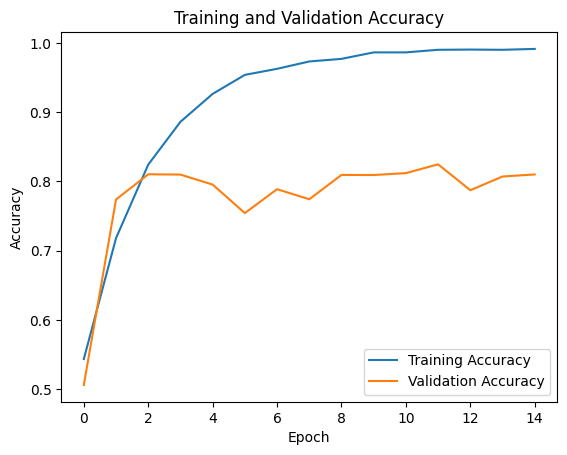

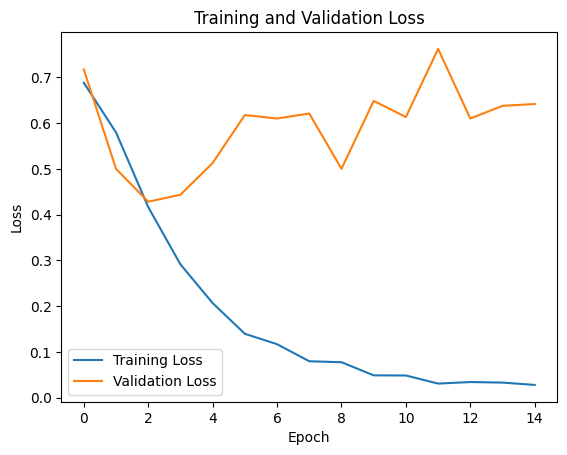

In [33]:
# Plot training and validation accuracy
plt.plot(hist1.history['accuracy'], label='Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist1.history['loss'], label='Training Loss')
plt.plot(hist1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Recognizing blurring and filling

Applying filtering to an Anchoring level


In [34]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=max_t, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
ou2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, ou2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [35]:
cb2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.x",
                                    save_best_only=True)
]
hist2=model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb2)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.x")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 [==============================] - 42s 338ms/step - loss: 0.6887 - accuracy: 0.5459 - val_loss: 0.6603 - val_accuracy: 0.6028
Epoch 2/15
100/100 [==============================] - 30s 298ms/step - loss: 0.5362 - accuracy: 0.7406 - val_loss: 0.4584 - val_accuracy: 0.7919
Epoch 3/15
100/100 [==============================] - 31s 313ms/step - loss: 0.3684 - accuracy: 0.8466 - val_loss: 0.4532 - val_accuracy: 0.8004
Epoch 4/15
100/100 [==============================] - 32s 324ms/step - loss: 0.2516 - accuracy: 0.9006 - val_loss: 0.3945 - val_accuracy: 0.8260
Epoch 5/15
100/100 [==============================] - 10s 104ms/step - loss: 0.1732 - accuracy: 0.9400 - val_loss: 0.4137 - val_accuracy: 0.8251
Epoch 6/15
100/100 [==============================] - 10s 98ms/step - loss: 0.1313 - accuracy: 0.9522 - val_loss: 0.6373 - val_accuracy: 0.7396
Epoch 7/15
100/100 [==============================] - 13s 129ms/step - loss: 0.0937 - accuracy: 0.9725 - val_loss: 0.4910 - val_acc

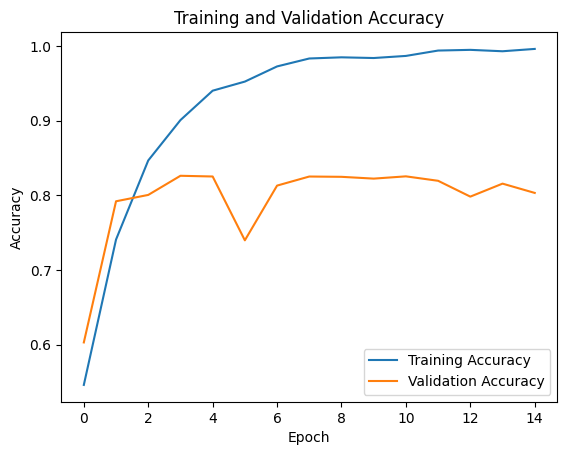

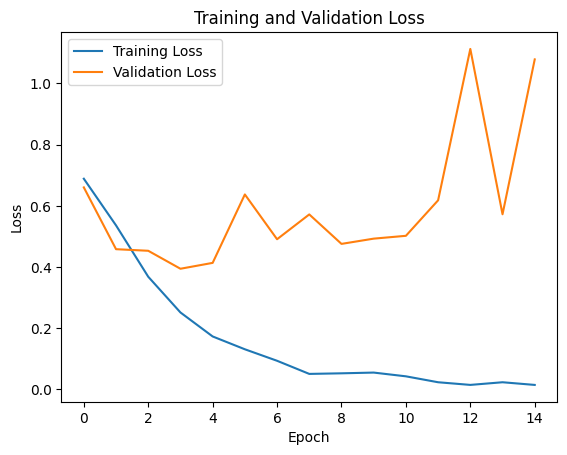

In [36]:
# Plot training and validation accuracy
plt.plot(hist2.history['accuracy'], label='Training Accuracy')
plt.plot(hist2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist2.history['loss'], label='Training Loss')
plt.plot(hist2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Preconditioned word embeds are used

In [37]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-05 21:06:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-05 21:06:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-05 21:06:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [38]:
import numpy as np
path_to_g_file = "glove.6B.100d.txt"

em_index = {}
with open(path_to_g_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        em_index[word] = coefs

print(f"Found {len(em_index)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [39]:
em_dim = 100

vocab = t_vectorization.get_vocabulary()
wo_index = dict(zip(vocab, range(len(vocab))))

em_matrix = np.zeros((max_t, em_dim))
for word, i in wo_index.items():
    if i < max_t:
        em_vector = em_index.get(word)
    if em_vector is not None:
        em_matrix[i] = em_vector

In [44]:
em_layer = layers.Embedding(
    max_t,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(em_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture with an embedded level which has been trained

In [45]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
ou4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, ou4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1034113 (3.94 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________

In [46]:
cb4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.x",
                                    save_best_only=True)
]
hist4=model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb4)
model = keras.models.load_model("glove_embeddings_sequence_model.x")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 [==============================] - 51s 429ms/step - loss: 0.6969 - accuracy: 0.5319 - val_loss: 0.6562 - val_accuracy: 0.6108
Epoch 2/15
100/100 [==============================] - 12s 119ms/step - loss: 0.6454 - accuracy: 0.6297 - val_loss: 0.6641 - val_accuracy: 0.5881
Epoch 3/15
100/100 [==============================] - 40s 407ms/step - loss: 0.5990 - accuracy: 0.6891 - val_loss: 0.5531 - val_accuracy: 0.7339
Epoch 4/15
100/100 [==============================] - 53s 531ms/step - loss: 0.5503 - accuracy: 0.7237 - val_loss: 0.5269 - val_accuracy: 0.7488
Epoch 5/15
100/100 [==============================] - 52s 521ms/step - loss: 0.5149 - accuracy: 0.7441 - val_loss: 0.5127 - val_accuracy: 0.7506
Epoch 6/15
100/100 [==============================] - 24s 245ms/step - loss: 0.5027 - accuracy: 0.7513 - val_loss: 0.6305 - val_accuracy: 0.6653
Epoch 7/15
100/100 [==============================] - 12s 124ms/step - loss: 0.4821 - accuracy: 0.7719 - val_loss: 0.5547 - val_ac

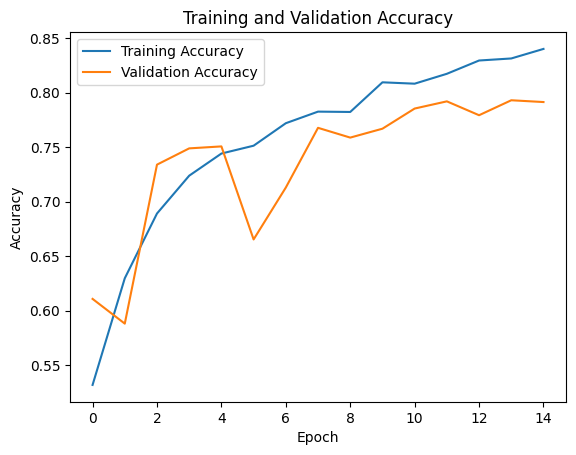

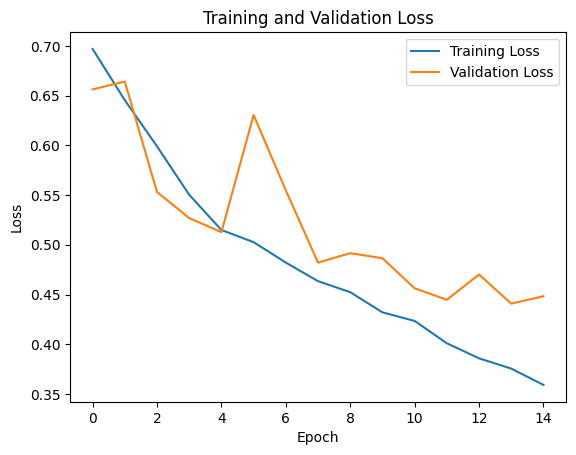

In [47]:
# Plot training and validation accuracy
plt.plot(hist4.history['accuracy'], label='Training Accuracy')
plt.plot(hist4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist4.history['loss'], label='Training Loss')
plt.plot(hist4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 47s 412ms/step - loss: 0.6923 - accuracy: 0.5194 - val_loss: 0.6893 - val_accuracy: 0.5648
Epoch 2/10
100/100 [==============================] - 32s 319ms/step - loss: 0.6367 - accuracy: 0.6597 - val_loss: 0.5643 - val_accuracy: 0.7372
Epoch 3/10
100/100 [==============================] - 27s 268ms/step - loss: 0.4816 - accuracy: 0.7981 - val_loss: 0.4994 - val_accuracy: 0.7679
Epoch 4/10
100/100 [==============================] - 23s 236ms/step - loss: 0.3440 - accuracy: 0.8666 - val_loss: 0.4453 - val_accuracy: 0.8093
Epoch 5/10
100/100 [==============================] - 27s 269ms/step - loss: 0.2375 - accuracy: 0.9103 - val_loss: 0.4000 - val_accuracy: 0.8316
Epoch 6/10
100/100 [==============================] - 25s 255ms/step - loss: 0.1923 - accuracy: 0.9281 - val_loss: 0.4644 - val_accuracy: 0.8268
Epoch 7/10
100/100 [==============================] - 11s 108ms/step - loss: 0.1296 - acc

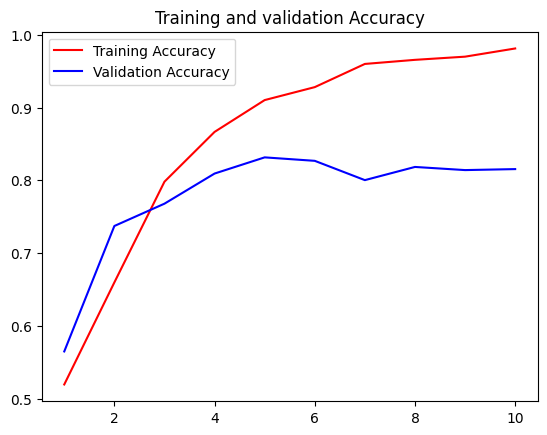

Epoch 1/10
100/100 [==============================] - 62s 495ms/step - loss: 0.6779 - accuracy: 0.5838 - val_loss: 0.6340 - val_accuracy: 0.6456
Epoch 2/10
100/100 [==============================] - 55s 557ms/step - loss: 0.6230 - accuracy: 0.6619 - val_loss: 0.6332 - val_accuracy: 0.6557
Epoch 3/10
100/100 [==============================] - 50s 508ms/step - loss: 0.5737 - accuracy: 0.7106 - val_loss: 0.5844 - val_accuracy: 0.6904
Epoch 4/10
100/100 [==============================] - 43s 435ms/step - loss: 0.5447 - accuracy: 0.7181 - val_loss: 0.5157 - val_accuracy: 0.7519
Epoch 5/10
100/100 [==============================] - 14s 145ms/step - loss: 0.5169 - accuracy: 0.7459 - val_loss: 0.5361 - val_accuracy: 0.7330
Epoch 6/10
100/100 [==============================] - 20s 199ms/step - loss: 0.5067 - accuracy: 0.7588 - val_loss: 0.5363 - val_accuracy: 0.7294
Epoch 7/10
100/100 [==============================] - 39s 393ms/step - loss: 0.4849 - accuracy: 0.7741 - val_loss: 0.4836 - val_ac

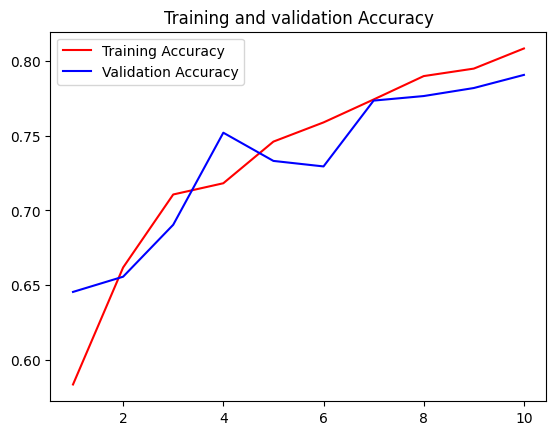

Training samples: 100
Embedding layer test accuracy: 0.804
Pretrained embeddings test accuracy: 0.781
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 [==============================] - 45s 254ms/step - loss: 0.6653 - accuracy: 0.5830 - val_loss: 0.5294 - val_accuracy: 0.7582
Epoch 2/10
157/157 [==============================] - 36s 228ms/step - loss: 0.4809 - accuracy: 0.7872 - val_loss: 0.4322 - val_accuracy: 0.8103
Epoch 3/10
157/157 [==============================] - 39s 250ms/step - loss: 0.3376 - accuracy: 0.8720 - val_loss: 0.4059 - val_accuracy: 0.8275
Epoch 4/10
157/157 [==============================] - 13s 84ms/step - loss: 0.2550 - accuracy: 0.9154 - val_loss: 0.6146 - val_accuracy: 0.7802
Epoch 5/10
157/157 [==============================] - 14s 88ms/step - loss: 0.1928 - accuracy: 0.9392 - val_loss: 0.4192 - val_accuracy: 0.8447
Epoch 6/10
157/157 [==============================] - 13s 83ms/step - loss: 0.1507 

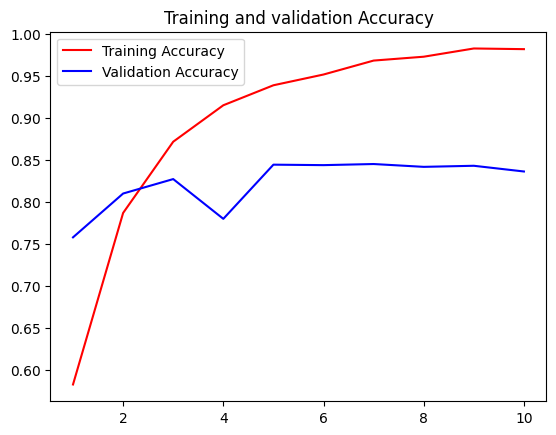

Epoch 1/10
157/157 [==============================] - 52s 259ms/step - loss: 0.6659 - accuracy: 0.5954 - val_loss: 0.6534 - val_accuracy: 0.6241
Epoch 2/10
157/157 [==============================] - 11s 71ms/step - loss: 0.5861 - accuracy: 0.6940 - val_loss: 0.6772 - val_accuracy: 0.6511
Epoch 3/10
157/157 [==============================] - 42s 266ms/step - loss: 0.5406 - accuracy: 0.7324 - val_loss: 0.5673 - val_accuracy: 0.6952
Epoch 4/10
157/157 [==============================] - 39s 252ms/step - loss: 0.5121 - accuracy: 0.7556 - val_loss: 0.4868 - val_accuracy: 0.7651
Epoch 5/10
157/157 [==============================] - 56s 359ms/step - loss: 0.4866 - accuracy: 0.7720 - val_loss: 0.4718 - val_accuracy: 0.7781
Epoch 6/10
157/157 [==============================] - 26s 167ms/step - loss: 0.4649 - accuracy: 0.7848 - val_loss: 0.5240 - val_accuracy: 0.7300
Epoch 7/10
157/157 [==============================] - 24s 154ms/step - loss: 0.4453 - accuracy: 0.7890 - val_loss: 0.5467 - val_acc

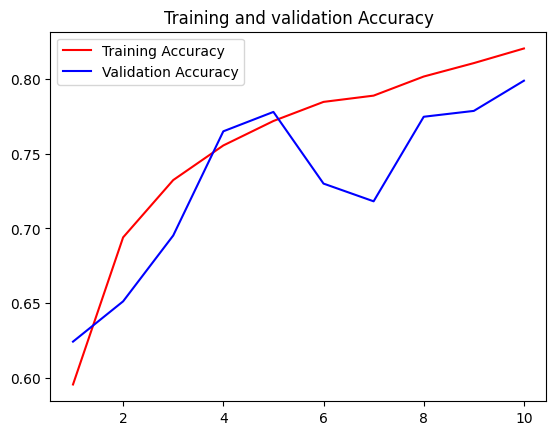

Training samples: 500
Embedding layer test accuracy: 0.790
Pretrained embeddings test accuracy: 0.786
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 [==============================] - 39s 213ms/step - loss: 0.6758 - accuracy: 0.5636 - val_loss: 0.6778 - val_accuracy: 0.6112
Epoch 2/10
157/157 [==============================] - 34s 217ms/step - loss: 0.5105 - accuracy: 0.7708 - val_loss: 0.4563 - val_accuracy: 0.7934
Epoch 3/10
157/157 [==============================] - 32s 203ms/step - loss: 0.3620 - accuracy: 0.8586 - val_loss: 0.4212 - val_accuracy: 0.8064
Epoch 4/10
157/157 [==============================] - 17s 107ms/step - loss: 0.2600 - accuracy: 0.9032 - val_loss: 0.4352 - val_accuracy: 0.8295
Epoch 5/10
157/157 [==============================] - 14s 87ms/step - loss: 0.1893 - accuracy: 0.9370 - val_loss: 0.5474 - val_accuracy: 0.8121
Epoch 6/10
157/157 [==============================] - 16s 100ms/step - loss: 0.139

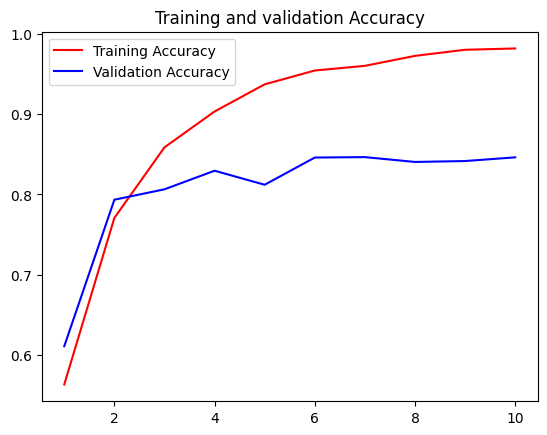

Epoch 1/10
157/157 [==============================] - 66s 373ms/step - loss: 0.6793 - accuracy: 0.5710 - val_loss: 0.6465 - val_accuracy: 0.6172
Epoch 2/10
157/157 [==============================] - 45s 285ms/step - loss: 0.6039 - accuracy: 0.6768 - val_loss: 0.5724 - val_accuracy: 0.6939
Epoch 3/10
157/157 [==============================] - 54s 344ms/step - loss: 0.5561 - accuracy: 0.7190 - val_loss: 0.5705 - val_accuracy: 0.7226
Epoch 4/10
157/157 [==============================] - 41s 261ms/step - loss: 0.5305 - accuracy: 0.7422 - val_loss: 0.5140 - val_accuracy: 0.7501
Epoch 5/10
157/157 [==============================] - 43s 274ms/step - loss: 0.4933 - accuracy: 0.7638 - val_loss: 0.4716 - val_accuracy: 0.7802
Epoch 6/10
157/157 [==============================] - 55s 355ms/step - loss: 0.4729 - accuracy: 0.7766 - val_loss: 0.4659 - val_accuracy: 0.7826
Epoch 7/10
157/157 [==============================] - 14s 91ms/step - loss: 0.4595 - accuracy: 0.7810 - val_loss: 0.4718 - val_acc

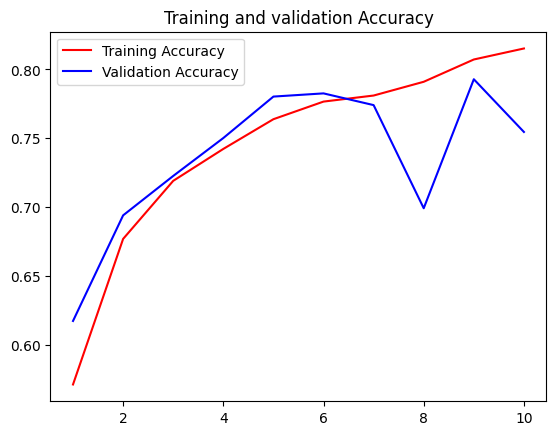

Training samples: 1000
Embedding layer test accuracy: 0.779
Pretrained embeddings test accuracy: 0.783
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 [==============================] - 40s 236ms/step - loss: 0.6913 - accuracy: 0.5272 - val_loss: 0.6756 - val_accuracy: 0.5905
Epoch 2/10
157/157 [==============================] - 34s 216ms/step - loss: 0.5669 - accuracy: 0.7254 - val_loss: 0.5124 - val_accuracy: 0.7502
Epoch 3/10
157/157 [==============================] - 28s 182ms/step - loss: 0.3797 - accuracy: 0.8498 - val_loss: 0.5074 - val_accuracy: 0.7425
Epoch 4/10
157/157 [==============================] - 28s 180ms/step - loss: 0.2854 - accuracy: 0.8992 - val_loss: 0.3963 - val_accuracy: 0.8274
Epoch 5/10
157/157 [==============================] - 13s 82ms/step - loss: 0.2133 - accuracy: 0.9248 - val_loss: 0.5384 - val_accuracy: 0.7796
Epoch 6/10
157/157 [==============================] - 25s 157ms/step - loss: 0.16

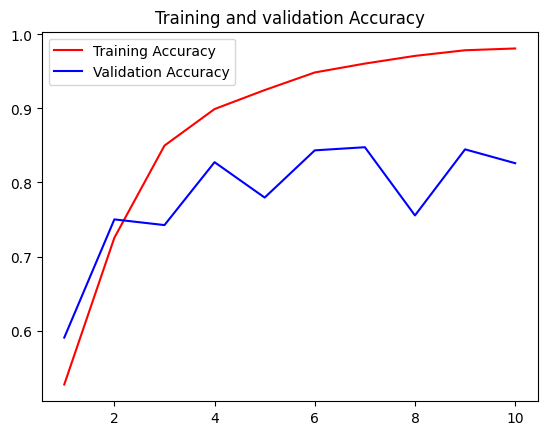

Epoch 1/10
157/157 [==============================] - 60s 300ms/step - loss: 0.6756 - accuracy: 0.5736 - val_loss: 0.6105 - val_accuracy: 0.6598
Epoch 2/10
157/157 [==============================] - 44s 282ms/step - loss: 0.5933 - accuracy: 0.6918 - val_loss: 0.5576 - val_accuracy: 0.7197
Epoch 3/10
157/157 [==============================] - 56s 356ms/step - loss: 0.5488 - accuracy: 0.7320 - val_loss: 0.5432 - val_accuracy: 0.7244
Epoch 4/10
157/157 [==============================] - 38s 244ms/step - loss: 0.5086 - accuracy: 0.7568 - val_loss: 0.5159 - val_accuracy: 0.7511
Epoch 5/10
157/157 [==============================] - 25s 163ms/step - loss: 0.4822 - accuracy: 0.7762 - val_loss: 0.7764 - val_accuracy: 0.6451
Epoch 6/10
157/157 [==============================] - 26s 166ms/step - loss: 0.4631 - accuracy: 0.7802 - val_loss: 0.7318 - val_accuracy: 0.6597
Epoch 7/10
157/157 [==============================] - 16s 100ms/step - loss: 0.4466 - accuracy: 0.7962 - val_loss: 0.5993 - val_ac

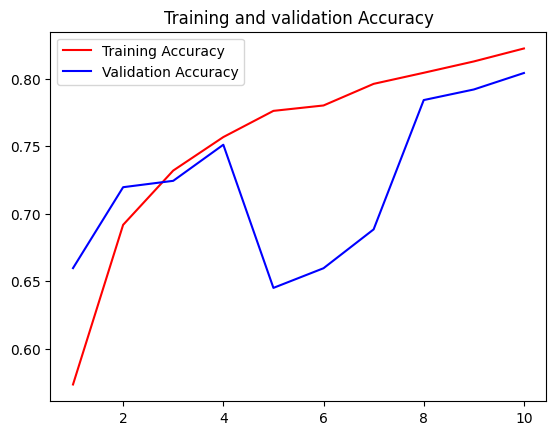

Training samples: 5000
Embedding layer test accuracy: 0.796
Pretrained embeddings test accuracy: 0.792
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 [==============================] - 36s 205ms/step - loss: 0.6812 - accuracy: 0.5572 - val_loss: 0.6748 - val_accuracy: 0.5362
Epoch 2/10
157/157 [==============================] - 46s 293ms/step - loss: 0.5116 - accuracy: 0.7698 - val_loss: 0.4843 - val_accuracy: 0.7878
Epoch 3/10
157/157 [==============================] - 30s 193ms/step - loss: 0.3605 - accuracy: 0.8598 - val_loss: 0.4621 - val_accuracy: 0.8126
Epoch 4/10
157/157 [==============================] - 30s 192ms/step - loss: 0.2717 - accuracy: 0.8972 - val_loss: 0.3891 - val_accuracy: 0.8420
Epoch 5/10
157/157 [==============================] - 12s 75ms/step - loss: 0.1889 - accuracy: 0.9316 - val_loss: 1.1166 - val_accuracy: 0.6988
Epoch 6/10
157/157 [==============================] - 16s 102ms/step - loss: 0.14

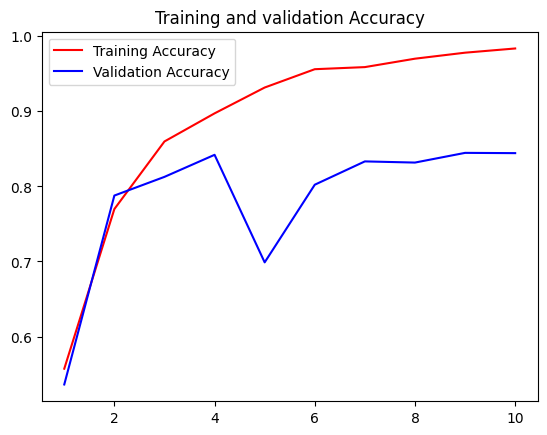

Epoch 1/10
157/157 [==============================] - 56s 300ms/step - loss: 0.6805 - accuracy: 0.5678 - val_loss: 0.7058 - val_accuracy: 0.5464
Epoch 2/10
157/157 [==============================] - 52s 331ms/step - loss: 0.6043 - accuracy: 0.6794 - val_loss: 0.5726 - val_accuracy: 0.7054
Epoch 3/10
157/157 [==============================] - 44s 285ms/step - loss: 0.5541 - accuracy: 0.7252 - val_loss: 0.5144 - val_accuracy: 0.7530
Epoch 4/10
157/157 [==============================] - 25s 160ms/step - loss: 0.5228 - accuracy: 0.7422 - val_loss: 0.6655 - val_accuracy: 0.6444
Epoch 5/10
157/157 [==============================] - 24s 151ms/step - loss: 0.4851 - accuracy: 0.7694 - val_loss: 0.5259 - val_accuracy: 0.7350
Epoch 6/10
157/157 [==============================] - 41s 265ms/step - loss: 0.4654 - accuracy: 0.7838 - val_loss: 0.4792 - val_accuracy: 0.7664
Epoch 7/10
157/157 [==============================] - 24s 151ms/step - loss: 0.4587 - accuracy: 0.7896 - val_loss: 0.5068 - val_ac

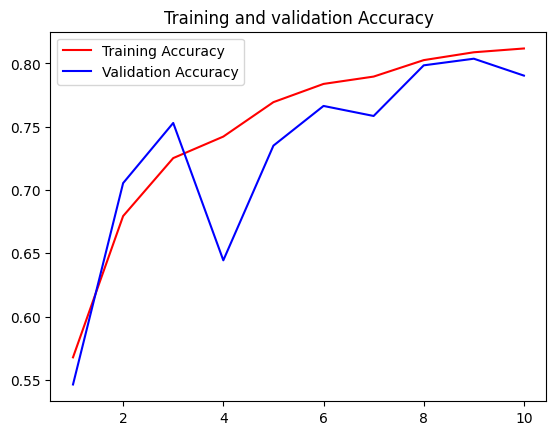

Training samples: 10000
Embedding layer test accuracy: 0.808
Pretrained embeddings test accuracy: 0.793
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 [==============================] - 47s 249ms/step - loss: 0.6901 - accuracy: 0.5380 - val_loss: 0.6424 - val_accuracy: 0.6642
Epoch 2/10
157/157 [==============================] - 34s 214ms/step - loss: 0.5503 - accuracy: 0.7324 - val_loss: 0.5139 - val_accuracy: 0.7484
Epoch 3/10
157/157 [==============================] - 26s 169ms/step - loss: 0.3790 - accuracy: 0.8504 - val_loss: 0.4787 - val_accuracy: 0.8194
Epoch 4/10
157/157 [==============================] - 40s 254ms/step - loss: 0.2752 - accuracy: 0.8996 - val_loss: 0.4001 - val_accuracy: 0.8287
Epoch 5/10
157/157 [==============================] - 32s 202ms/step - loss: 0.2028 - accuracy: 0.9324 - val_loss: 0.3981 - val_accuracy: 0.8415
Epoch 6/10
157/157 [==============================] - 13s 85ms/step - loss: 0.1

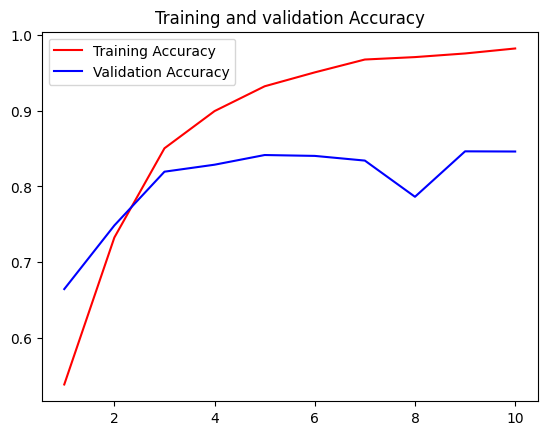

Epoch 1/10
157/157 [==============================] - 66s 353ms/step - loss: 0.6773 - accuracy: 0.5732 - val_loss: 0.6536 - val_accuracy: 0.6439
Epoch 2/10
157/157 [==============================] - 42s 270ms/step - loss: 0.6003 - accuracy: 0.6812 - val_loss: 0.6045 - val_accuracy: 0.6680
Epoch 3/10
157/157 [==============================] - 40s 257ms/step - loss: 0.5493 - accuracy: 0.7222 - val_loss: 0.5216 - val_accuracy: 0.7438
Epoch 4/10
157/157 [==============================] - 49s 310ms/step - loss: 0.5176 - accuracy: 0.7524 - val_loss: 0.4907 - val_accuracy: 0.7669
Epoch 5/10
157/157 [==============================] - 27s 172ms/step - loss: 0.4951 - accuracy: 0.7668 - val_loss: 0.9450 - val_accuracy: 0.5706
Epoch 6/10
157/157 [==============================] - 11s 67ms/step - loss: 0.4784 - accuracy: 0.7742 - val_loss: 0.8269 - val_accuracy: 0.6072
Epoch 7/10
157/157 [==============================] - 26s 165ms/step - loss: 0.4620 - accuracy: 0.7852 - val_loss: 0.5271 - val_acc

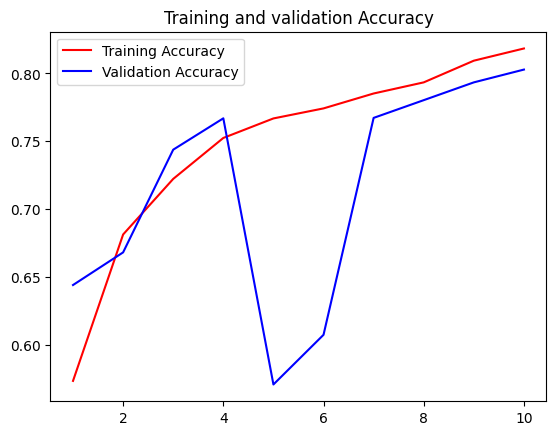

Training samples: 20000
Embedding layer test accuracy: 0.804
Pretrained embeddings test accuracy: 0.793
--------------------------------------------------


In [49]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=b_size
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = v_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = te_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(max_t, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.x")
    embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        max_t,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(em_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.x")
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)